In [1]:
import numpy as np
import os
import h5py
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

num_points = 2048
k = 40

In [8]:
path = os.path.dirname("../data/")
train_path = os.path.join(path, "train")
filenames = [d for d in os.listdir(train_path)]
print(train_path)
print(filenames)
train_points = None
train_labels = None
for d in filenames:
    if not d.endswith(".h5"): continue
    cur_points, cur_labels = load_h5(os.path.join(train_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if train_labels is None or train_points is None:
        train_labels = cur_labels
        train_points = cur_points
    else:
        train_labels = np.hstack((train_labels, cur_labels))
        train_points = np.hstack((train_points, cur_points))
train_points_r = train_points.reshape(-1, num_points, 3)
train_labels_r = train_labels.reshape(-1, 1)

# load test points and labels
test_path = os.path.join(path, "test")
filenames = [d for d in os.listdir(test_path)]
print(test_path)
print(filenames)
test_points = None
test_labels = None
for d in filenames:
    if not d.endswith(".h5"): continue
    cur_points, cur_labels = load_h5(os.path.join(test_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if test_labels is None or test_points is None:
        test_labels = cur_labels
        test_points = cur_points
    else:
        test_labels = np.hstack((test_labels, cur_labels))
        test_points = np.hstack((test_points, cur_points))
test_points_r = test_points.reshape(-1, num_points, 3)
test_labels_r = test_labels.reshape(-1, 1)

Y_train = np_utils.to_categorical(train_labels_r, k)
Y_test = np_utils.to_categorical(test_labels_r, k)

../data\train
['.gitignore', 'ply_data_train0.h5', 'ply_data_train1.h5', 'ply_data_train2.h5', 'ply_data_train3.h5', 'ply_data_train4.h5']
../data\test
['.gitignore', 'ply_data_test0.h5', 'ply_data_test1.h5']


In [11]:
def plane_xequal1(point):
    return (point[1], point[2], 1 - point[0])
def plane_yequal1(point):
    return (point[0], point[2], 1 - point[1])
def plane_zequal1(point):
    return (point[0], point[1], 1 - point[2])
def plane_xequal_neg1(point):
    return (point[1], point[2], abs(-1 - point[0]))
def plane_yequal_neg1(point):
    return (point[0], point[2], abs(-1 - point[1]))
def plane_zequal_neg1(point):
    return (point[0], point[1], abs(-1 - point[2]))

planes = [plane_xequal1, plane_yequal1, plane_zequal1, plane_xequal_neg1, plane_yequal_neg1, plane_zequal_neg1]

In [12]:
def rasterize(point_cloud, img_width, img_height, planes):
    channels = len(planes)
    projections = []
    for plane in planes:
        projection = [plane(point) for point in point_cloud]
        projections.append(projection)
    projections = np.array(projections)
    projections[:,:,0:2] = (projections[:,:,0:2] * (img_width/2) + (img_width/2)).astype(np.int16)
    projections[:,:,2] = projections[:,:,2]/2
    
    img = np.zeros((channels, img_width, img_height))
    for i in range(channels):
        projection = projections[i]
        rev_intensity = projection[projection[:,2].argsort()]
        rev_intensity = rev_intensity[::-1]
        for point in rev_intensity:
            img[i][int(point[0])][int(point[1])] = 1 - point[2]
    return img

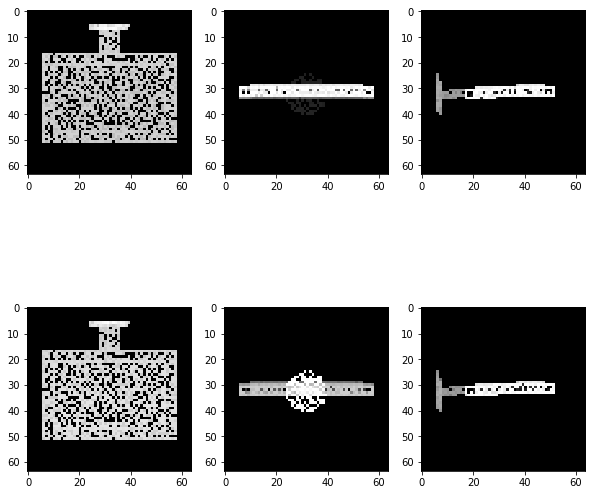

In [34]:
index = 500
point_cloud = train_points_r[index]
img = rasterize(point_cloud, 64, 64, planes)
plt.figure(figsize=(10, 10))
for i in range(len(planes)):
    plt.subplot(2, 3, i+1)
    plt.imshow(img[i], cmap="gray")

<br><br><br><br>
<br><br><br><br><hr>